In [1]:
from pprint import pprint as p

# Goals 

Calculate activity
- [ ] Check value distribution
- [ ] Implement activity mapping

Check how those affect activity
- [ ] COMPONENT_TYPE
- [ ] ORGANISM
- [ ] assay_type and

In [2]:
! ls ../data/chembl_36/chembl_36_sqlite/

chembl_36.db  INSTALL_sqlite


In [3]:
import sqlite3
db_file_path = "../data/chembl_36/chembl_36_sqlite/chembl_36.db"
try:
    cn = sqlite3.connect(db_file_path)
    cursor = cn.cursor()
except sqlite3.Error as e:
    print(e)

# Matching Data

In [37]:
types: tuple[str] = ("IC50","GI50", "Ki", "EC50")
# Kd could be a type but most of the data is censored
standard_type = types[0]

In [38]:
query = f"""
SELECT
  act.value,
  act.units,
  act.standard_value,
  act.standard_units
FROM activities AS act
JOIN assays AS ass
  ON ass.assay_id = act.assay_id
WHERE act.standard_type = '{standard_type}'
  AND act.potential_duplicate = 0
  AND (
    ass.assay_organism IN ('Homo sapiens', 'Mus musculus', 'Rattus norvegicus')
    OR ass.assay_tax_id IN (9606, 10090, 10116)
  )
"""

p(query)

('\n'
 'SELECT\n'
 '  act.value,\n'
 '  act.units,\n'
 '  act.standard_value,\n'
 '  act.standard_units\n'
 'FROM activities AS act\n'
 'JOIN assays AS ass\n'
 '  ON ass.assay_id = act.assay_id\n'
 "WHERE act.standard_type = 'IC50'\n"
 '  AND act.potential_duplicate = 0\n'
 '  AND (\n'
 "    ass.assay_organism IN ('Homo sapiens', 'Mus musculus', 'Rattus "
 "norvegicus')\n"
 '    OR ass.assay_tax_id IN (9606, 10090, 10116)\n'
 '  )\n')


In [39]:
def standarize_units(value: float, unit: str) -> float:
    u = unit.strip().lower()
    v = float(value)
    m = {
        "m": 1.0,
        "mm": 1e-3,
        "um": 1e-6,
        "µm": 1e-6,
        "nm": 1e-9,
        "pm": 1e-12,
    }
    if u in m:
        return v * m[u]
    return None

In [40]:
from array import array
CHUNK_SIZE = 50_000
dists = array("d")  # compact storage for floats
with sqlite3.connect(db_file_path) as cn:
    cur = cn.cursor()
    cur.execute(query)
    fetch = cur.fetchmany
    rows = fetch(CHUNK_SIZE)
    while rows:
        for v, u, sv, su in rows:
            if v is None or u is None or sv is None or su is None:
                continue
            a = standarize_units(v, u)
            if a is None:
                continue
            b = standarize_units(sv, su)
            if b is None or a != b:
                continue
            dists.append(a)
        rows = fetch(CHUNK_SIZE)

In [41]:
print(len(dists))

1100531


In [42]:
import matplotlib.pyplot as plt
import math

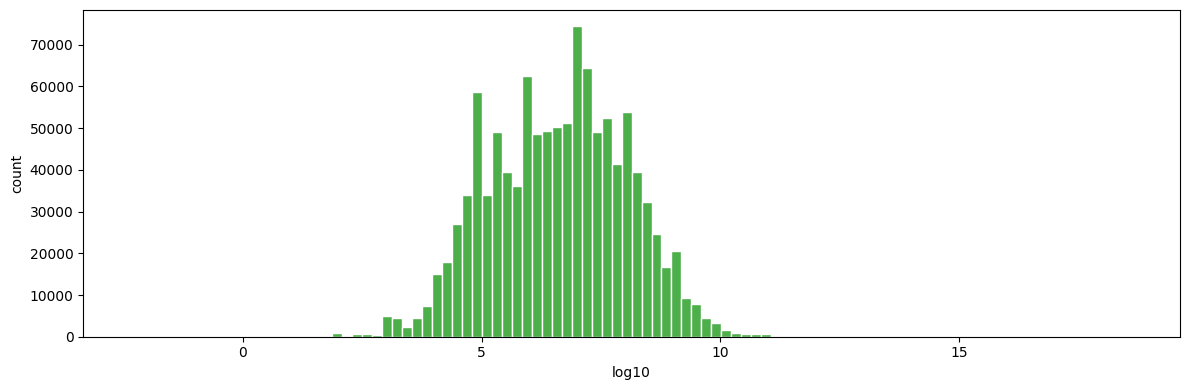

In [61]:
plt.figure(figsize=(12, 4))

log_vals = [-math.log10(x) for x in dists if x > 0]
plt.hist(log_vals, bins=100, color="#4daf4a", edgecolor="white")
plt.xlabel("log10")
plt.ylabel("count")

plt.tight_layout()
plt.show()

> This is ai generated

In [58]:
import sqlite3
import math
from collections import defaultdict, Counter
from array import array
import matplotlib.pyplot as plt

CHUNK_SIZE = 50_000

def stream_by_type(std_type: str):
    sql = """
    SELECT
      act.value,
      act.units,
      act.standard_value,
      act.standard_units,
      ass.assay_organism,
      ass.assay_type,
      cs.component_type
    FROM activities AS act
    JOIN assays AS ass
      ON ass.assay_id = act.assay_id
    LEFT JOIN target_dictionary AS td
      ON td.tid = ass.tid
    LEFT JOIN target_components AS tc
      ON tc.tid = td.tid
    LEFT JOIN component_sequences AS cs
      ON cs.component_id = tc.component_id
    WHERE act.standard_type = ?
      AND act.potential_duplicate = 0
      AND (
        ass.assay_organism IN ('Homo sapiens', 'Mus musculus', 'Rattus norvegicus')
        OR ass.assay_tax_id IN (9606, 10090, 10116)
      )
    """
    all_vals = array("d")
    by_org = defaultdict(list)
    by_assay_type = defaultdict(list)
    by_comp = defaultdict(list)

    with sqlite3.connect(db_file_path) as cn:
        cur = cn.cursor()
        cur.execute(sql, (std_type,))
        rows = cur.fetchmany(CHUNK_SIZE)
        while rows:
            for v, u, sv, su, org, assay_t, comp_t in rows:
                if v is None or u is None or sv is None or su is None:
                    continue
                a = standarize_units(v, u)
                if a is None:
                    continue
                b = standarize_units(sv, su)
                if b is None or a != b:
                    continue
                if a > 0:
                    logv = -math.log10(a)
                    all_vals.append(logv) 
                    by_org[org].append(logv)
                    by_assay_type[assay_t].append(logv)
                    by_comp[comp_t].append(logv)
            rows = cur.fetchmany(CHUNK_SIZE)

    return all_vals, by_org, by_assay_type, by_comp

In [59]:
def plot_groups(ax, groups, title, top_n=6):
    counts = Counter({k: len(v) for k, v in groups.items() if k is not None})
    for i, (k, _) in enumerate(counts.most_common(top_n)):
        ax.hist(groups[k], bins=100, alpha=0.6, label=f"{k} (n={len(groups[k]):,})")
    ax.set_title(title)
    ax.set_xlabel("log10")
    ax.set_ylabel("count")
    if counts:
        ax.legend()

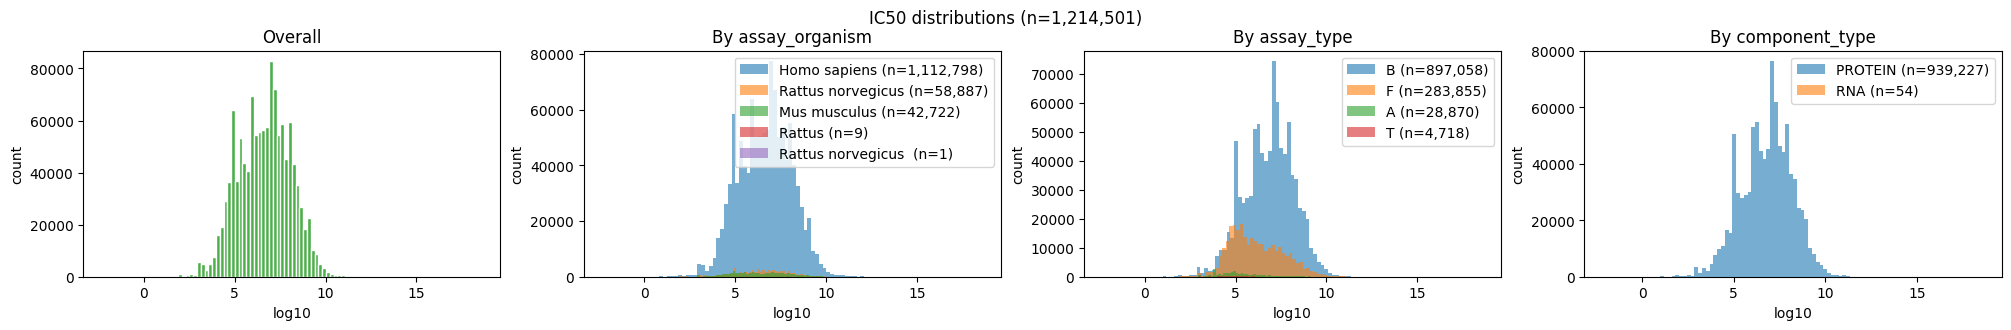

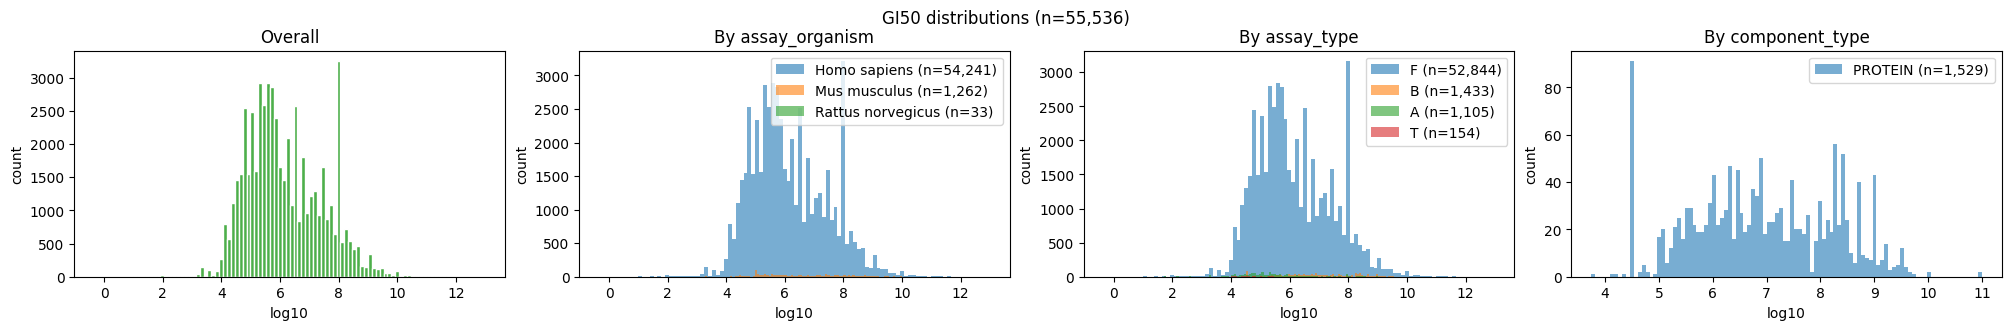

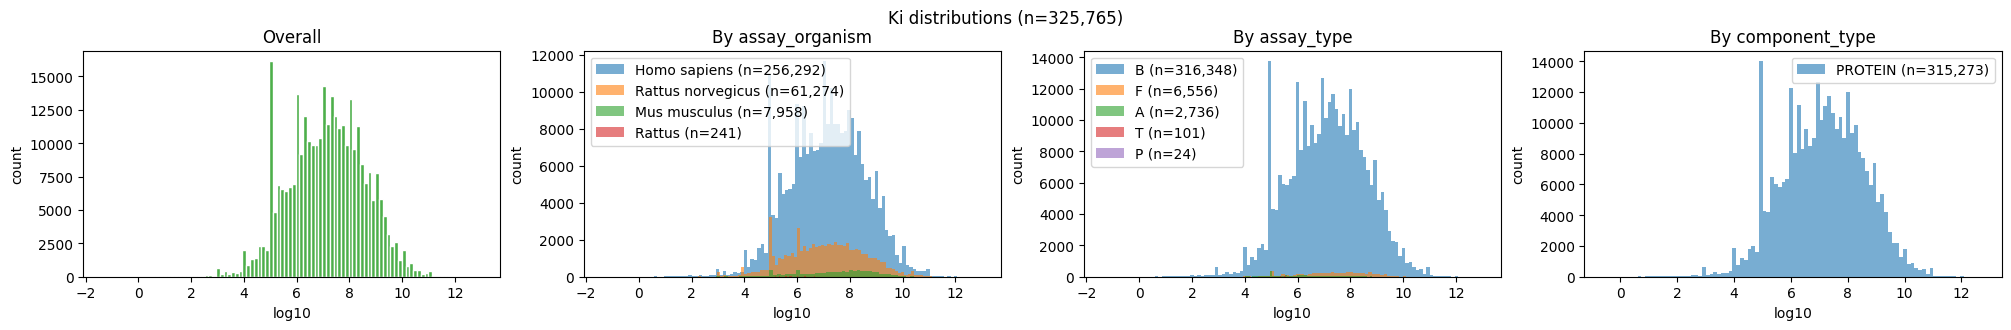

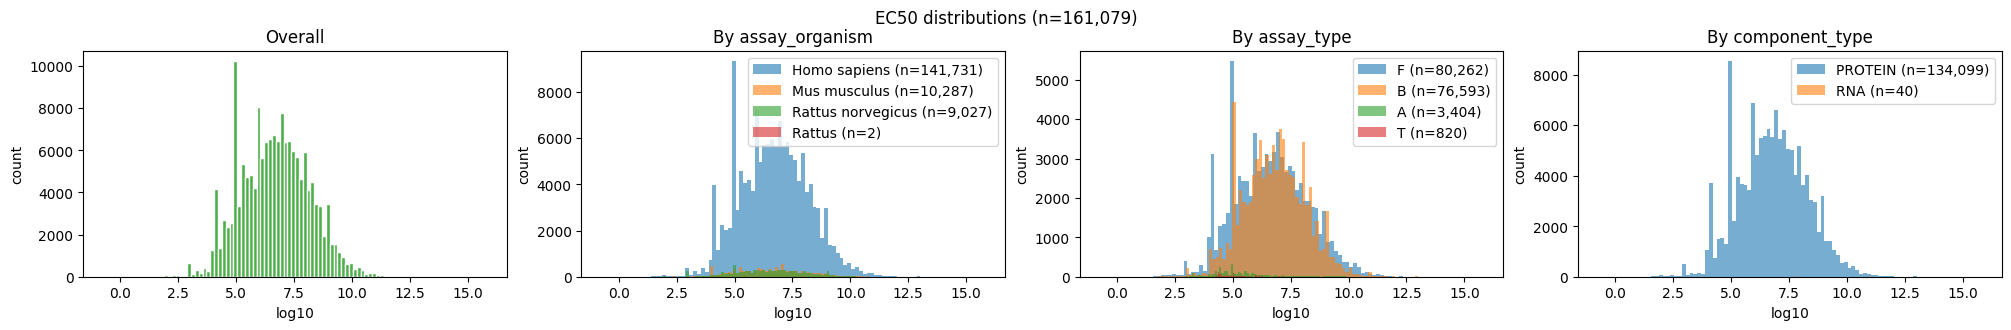

In [60]:
all_axes = []
for std_type in types:
    log_vals, by_org, by_assay, by_comp = stream_by_type(std_type)

    fig, axes = plt.subplots(1, 4, figsize=(20, 3), constrained_layout=True)
    fig.suptitle(f"{std_type} distributions (n={len(log_vals):,})", y=1.05)

    axes[0].hist(log_vals, bins=100, color="#4daf4a", edgecolor="white")
    axes[0].set_title("Overall")
    axes[0].set_xlabel("log10")
    axes[0].set_ylabel("count")

    plot_groups(axes[1], by_org, "By assay_organism")
    plot_groups(axes[2], by_assay, "By assay_type")
    plot_groups(axes[3], by_comp, "By component_type")

    all_axes.append((fig, axes))

plt.show()